# Deep learning tests

## Load libraries and data

In [2]:
import scipy.io as scio
from scipy.interpolate import CubicSpline
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model
import torch
import torch.nn
import torch.nn.functional
import torch.utils.data
import tqdm
data = scio.loadmat('tissue14.mat')
calibration = scio.loadmat('cal_14.mat')

In [ ]:
# Look at imported data
for key, value in data.items():
    try:
        print(key, value.shape)
    except:
        print(key, len(value))

## Visualise data 

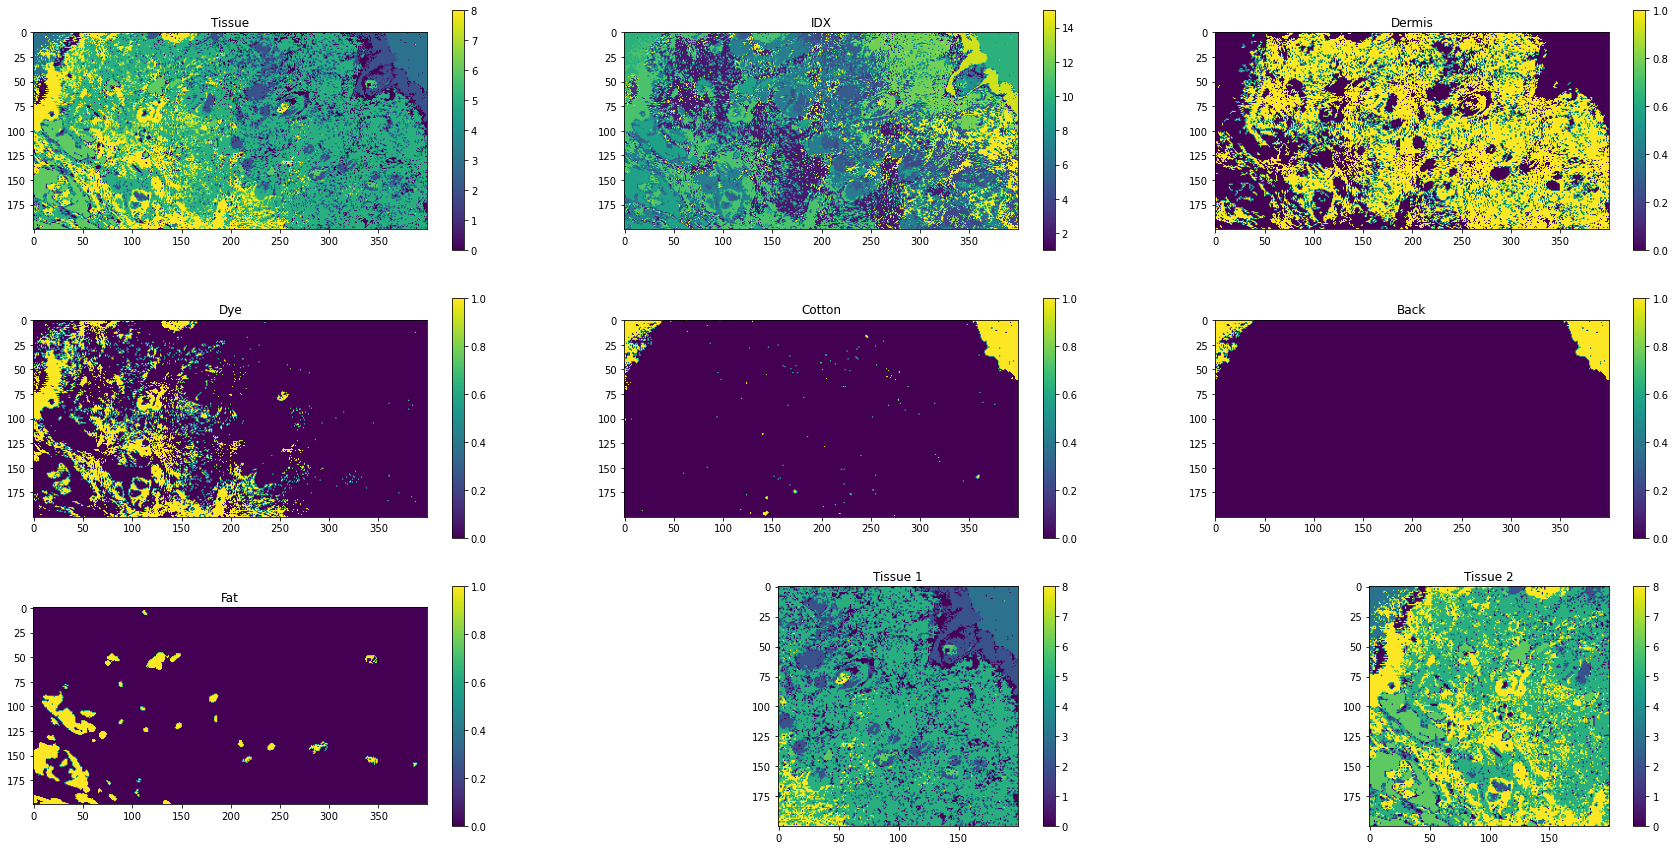

In [63]:
fig, axs = plt.subplots(3,3, figsize=(30,15))

im1 = axs[0,0].imshow(data['tissue_t14'])
fig.colorbar(im1, ax=axs[0,0])
axs[0,0].title.set_text('Tissue')

im2 = axs[0,1].imshow(data['IDX'])
fig.colorbar(im2, ax=axs[0,1])
axs[0,1].title.set_text('IDX')

im3 = axs[0,2].imshow(data['dermis'])
fig.colorbar(im3, ax=axs[0,2])
axs[0,2].title.set_text('Dermis')

im4 = axs[1,0].imshow(data['dye'])
fig.colorbar(im4, ax=axs[1,0])
axs[1,0].title.set_text('Dye')

im5 = axs[1,1].imshow(data['cotton'])
fig.colorbar(im5, ax=axs[1,1])
axs[1,1].title.set_text('Cotton')

im6 = axs[1,2].imshow(data['back'])
fig.colorbar(im6, ax=axs[1,2])
axs[1,2].title.set_text('Back')

im7 = axs[2,0].imshow(data['fat'])
fig.colorbar(im7, ax=axs[2,0])
axs[2,0].title.set_text('Fat')

im1 = axs[2,1].imshow(data['tissue_t14_1'])
fig.colorbar(im1, ax=axs[2,1])
axs[2,1].title.set_text('Tissue 1')

im1 = axs[2,2].imshow(data['tissue_t14_2'])
fig.colorbar(im1, ax=axs[2,2])
axs[2,2].title.set_text('Tissue 2')

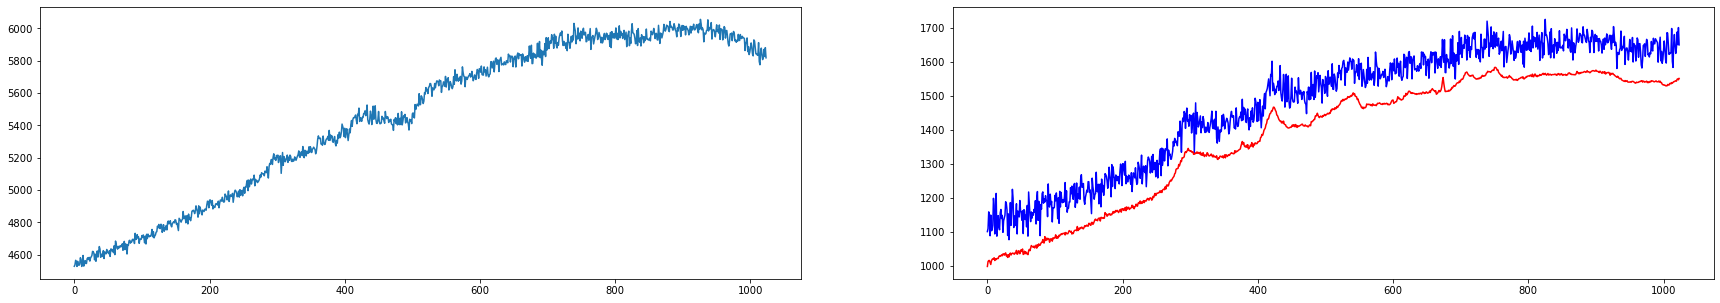

In [118]:
fig, axs = plt.subplots(1,2, figsize=(30,5))
axs[0].plot(data['map_t14'][50,50,:])
axs[1].plot(data['map_t14_c'][50,50,:], color='blue')
axs[1].plot(data['map_t14_svd'][50,50,:], color='red')

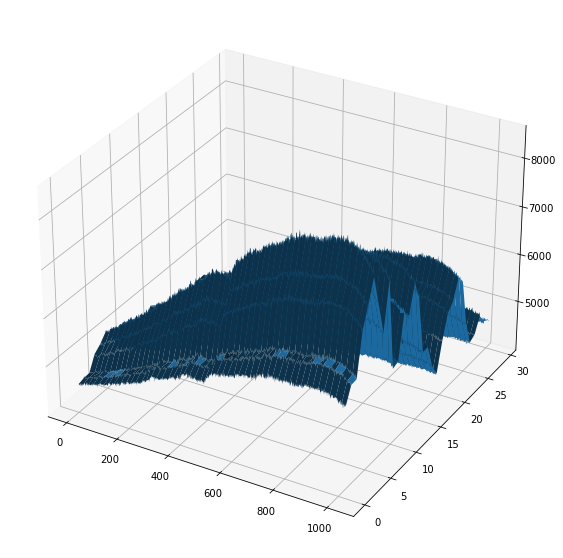

In [81]:
from mpl_toolkits import mplot3d

def f(x, y):
    return data['map_t14'][50,50+x,y]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x = np.arange(30)
y = np.arange(1024)
x,y = np.meshgrid(x,y)
z = f(x,y)

surf = ax.plot_surface(y,x, z)
plt.show()

In [3]:
target = data['tissue_t14_2']
tissue_data = data['map_t14_2']    

## Get calibration values

In [84]:
# Look at imported data
for key, value in calibration.items():
    try:
        print(key, value.shape)
    except:
        print(key, len(value))

__header__ 76
__version__ 3
__globals__ 0
Cal (1, 1)


In [120]:
wavenumber    = calibration['Cal'][0][0][0]
response      = calibration['Cal'][0][0][1]
pixel_offset  = calibration['Cal'][0][0][2]
background    = calibration['Cal'][0][0][3][0][0][2]

First wavenumber = [10659.35014773]
Last wavenumber = [12414.73969554]


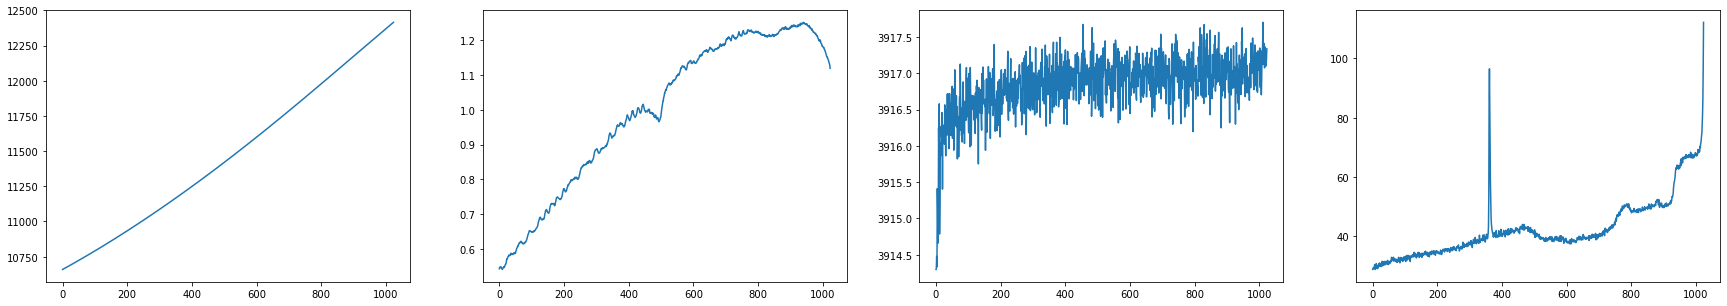

In [101]:
fig, axs = plt.subplots(1,4, figsize=(30,5))
axs[0].plot(wavenumber)
axs[1].plot(response)
axs[2].plot(pixel_offset)
axs[3].plot(background)

print('First wavenumber = ' + str(wavenumber[0]))
print('Last wavenumber = ' + str(wavenumber[-1]))

## Reduce data - relevant segments

In [28]:
segments = [(60,75),(370,385),(450,465),(665,680),(800,850)]

In [37]:
segment = [[] for i in range(200)]
segmented_spectra = [segment.copy() for i in range(200)]

for i in range(200):
    for j in range(200):
        spectra = []
        for (start,end) in segments:
            for data_pt in tissue_data[i,j,start:end]:
                spectra.append(data_pt)
        segmented_spectra[i][j] = spectra

In [142]:
segmented_no_bl = [segment.copy() for i in range(200)]

for i in range(200):
    for j in range(200):
        spectra = []
        for (start,end) in segments:
            for data_pt in tissue_no_bl[i,j,start:end]:
                spectra.append(data_pt)
        segmented_no_bl[i][j] = spectra

## Baseline removal

In [137]:
def remove_baseline(spectrum, window_size=64):
    """
    Use rubber-band method to remove baseline from spectrum
    Input:  - spectrum: np.array
            - window_size (optional): size of rubber-band window
    Output: - smoothed_spectrum: spectrum after baseline removal
    """
    spectrum_len = len(spectrum)  
    num_intervals = int(spectrum_len//window_size)
    
    # Get min value at each interval
    min_values = []
    min_indexes = []
    
    for k in range(int(num_intervals)):
        min_value = np.amax(spectrum[window_size*k : window_size*(k+1)])
        min_index = np.argmax(spectrum[window_size*k : window_size*(k+1)]) + window_size*k
        min_values.append(min_value)
        min_indexes.append(min_index)

    # Fit cubic spline
    cs = CubicSpline(min_indexes,min_values)

    # Remove spline from original spectrum
    smoothed_spectrum = np.zeros(spectrum_len)  
    for i in range(1024):
        smoothed_spectrum[i] = spectrum[i] - cs(i)
            
    return smoothed_spectrum
        

In [141]:
tissue_no_bl = tissue_data.copy()

for i in range(200):
    for j in range(200):
        tissue_no_bl[i,j,:] = remove_baseline(tissue_data[i,j,:])


## Simplify data more 

In [4]:
target_simple = target.copy()
for i in range(200):
    for j in range(200):
        if target[i,j] == 2:
            target_simple[i,j]=1
        if target[i,j] == 3:
            target_simple[i,j]=2
        if target[i,j] == 5:
            target_simple[i,j]=3
        if target[i,j] == 6:
            target_simple[i,j]=4
        if target[i,j] == 8:
            target_simple[i,j]=5

In [5]:
myset = set(target_simple.flatten()) 
print(myset)

{0, 1, 2, 3, 4, 5}


In [103]:
fake_data = tissue_data.copy()
import random 
p = 0.9

for i in range(200):
    for j in range(200):
        this_spectra = np.zeros(1024)

        for k in range(128):
            if random.random() < p:
                this_spectra[k] = target_simple[i,j]
            else:
                this_spectra[k] = random.randint(0,5)
        
        fake_data[i,j,:] = this_spectra

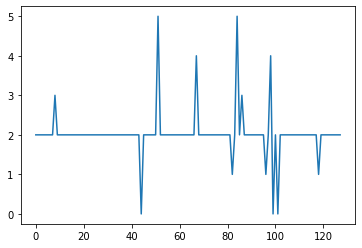

In [119]:
plt.plot(fake_data[10,10,0:128])

## Feedforward neural network

In [105]:
X = []
for i in range(200):
    for j in range(200):
        X.append(fake_data[i,j,0:128])
        
y = []
for i in range(200):
    for j in range(200):
        y.append(target_simple[i,j])

In [106]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.25)

scaler = sklearn.preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [174]:
class FeedforwardNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.pool1 = torch.nn.AvgPool1d(3, stride=2, padding=1)
        self.pool2 = torch.nn.AvgPool1d(3, stride=2, padding=1)
        self.pool3 = torch.nn.AvgPool1d(3, stride=2, padding=1)
        self.fc2 = torch.nn.Linear(16, 6)
        self.softmax = torch.nn.Softmax(dim=1)  
    
    def forward(self, x):
        output = self.pool1(x)
        output = self.pool2(output)
        output = self.pool3(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

In [175]:
model = FeedforwardNeuralNetwork()

In [109]:
tensor_X_train = torch.Tensor(X_train)
tensor_y_train = torch.Tensor(y_train).long()

dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
        sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=20000, drop_last=False))

In [153]:
criterion = torch.nn.CrossEntropyLoss() 

learning_rate = 0.1
num_epochs = 1000

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [176]:
model.train();

In [177]:
loss_history = []
accuracy_history = []
for epoch in tqdm.trange(num_epochs):
    for i, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        #correct = (torch.argmax(y_pred, dim=1) == targets).type(torch.FloatTensor)
        #accuracy_history.append(correct.mean())

100%|██████████| 1000/1000 [00:34<00:00, 29.26it/s]


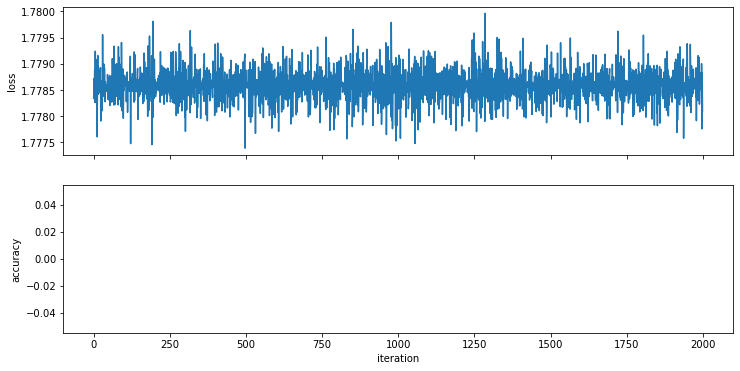

In [178]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(loss_history)
ax1.set_ylabel('loss')
ax2.plot(accuracy_history)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('iteration');

### Let's see how the model does...

In [179]:
model.eval();

In [180]:
tensor_X_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test).long()

y_pred_train = model(tensor_X_train) # 32000
y_pred_test = model(tensor_X_test)   #  8000

In [181]:
results = []

for item in y_pred_train:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)

for item in y_pred_test:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)
    
approximation = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        index = i*200 + j
        approximation[i,j] = results[index]

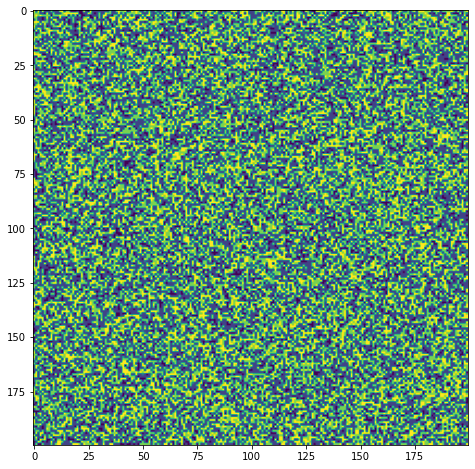

In [182]:
plt.figure(figsize=(8,8))
plt.imshow(approximation)